In [1]:
import torch
torch.set_default_dtype(torch.float64)

from mlcolvar.data import DictModule
from mlcolvar.utils.io import load_dataframe, create_dataset_from_trajectories
from mlcolvar.cvs.committor.utils import compute_committor_weights

# number of atoms
n_atoms=10

# temperature in Kelvin
T = 300 

# Boltzmann factor in the RIGHT ENERGY UNITS!
kb = 0.0083144621 # kJ/mol
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

load_args = [{'start' : 0, 'stop' : 10000, 'stride' : 10},
               {'start' : 0, 'stop' : 10000, 'stride' : 10},
               {'start' : 10000, 'stop' : 20000, 'stride' : 1}]
dataset = create_dataset_from_trajectories(
    trajectories=[
        "/home/etrizio@iit.local/alad/boundary/A/alad.trr",
        "/home/etrizio@iit.local/alad/boundary/B/alad.trr",
        "/home/etrizio@iit.local/alad/iteration_1/md/alad.trr"
    ],
    top=[
        "/home/etrizio@iit.local/alad/boundary/A/alad.gro",
        "/home/etrizio@iit.local/alad/boundary/B/alad.gro",
        "/home/etrizio@iit.local/alad/boundary/A/alad.gro"
         ],
    cutoff=10.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False,
    load_args=load_args
    )

bias = torch.zeros(len(dataset))
bias[-10000:] = torch.Tensor(load_dataframe("/home/etrizio@iit.local/alad/iteration_1/md/colvar", start=10000, stop=20000, stride=1)['opes.bias'])

dataset = compute_committor_weights(dataset=dataset, bias=bias, data_groups=[0,1,2], beta=beta)

datamodule_graph = DictModule(dataset, lengths=[1], shuffle=False)
print(datamodule_graph)

Beta: 0.4009078751268027 
1/beta: 2.4943386299999997
[ACE1-CH3, ACE1-C, ACE1-O, ALA2-N, ALA2-CA, ALA2-CB, ALA2-C, ALA2-O, NME3-N, NME3-C]
tensor([1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.4676e-04, 2.0101e-05,
        3.9714e+00])
DictModule(dataset -> DictDataset( "data_list": 12000, "z_table": [6, 7, 8], "cutoff": 10.0, "used_idx": tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), "used_names": [ACE1-CH3, ACE1-C, ACE1-O, ALA2-N, ALA2-CA, ALA2-CB, ALA2-C, ALA2-O, NME3-N, NME3-C], "data_type": graphs ),
		     train_loader -> DictLoader(length=1, batch_size=12000, shuffle=False))


In [ ]:
dataset['data_list'][-10:]

[Data(edge_index=[2, 90], shifts=[90, 3], unit_shifts=[90, 3], positions=[10, 3], cell=[3, 3], node_attrs=[10, 3], graph_labels=2.0, n_system=[1, 1], n_env=[1, 1], weight=2.544331344620953, names_idx=[10]),
 Data(edge_index=[2, 90], shifts=[90, 3], unit_shifts=[90, 3], positions=[10, 3], cell=[3, 3], node_attrs=[10, 3], graph_labels=2.0, n_system=[1, 1], n_env=[1, 1], weight=0.5654417280661564, names_idx=[10]),
 Data(edge_index=[2, 90], shifts=[90, 3], unit_shifts=[90, 3], positions=[10, 3], cell=[3, 3], node_attrs=[10, 3], graph_labels=2.0, n_system=[1, 1], n_env=[1, 1], weight=2.4702787408611155, names_idx=[10]),
 Data(edge_index=[2, 90], shifts=[90, 3], unit_shifts=[90, 3], positions=[10, 3], cell=[3, 3], node_attrs=[10, 3], graph_labels=2.0, n_system=[1, 1], n_env=[1, 1], weight=4.25943931484535, names_idx=[10]),
 Data(edge_index=[2, 90], shifts=[90, 3], unit_shifts=[90, 3], positions=[10, 3], cell=[3, 3], node_attrs=[10, 3], graph_labels=2.0, n_system=[1, 1], n_env=[1, 1], weight=

In [23]:
from mlcolvar.cvs.committor import Committor
from mlcolvar.core.nn.graph.schnet import SchNetModel
import torch

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset.metadata['cutoff'],
                        atomic_numbers=dataset.metadata['z_table'],
                        n_bases=16,
                        n_layers=2,
                        n_filters=16,
                        n_hidden_channels=16,
                        w_out_after_sum=True,
                        aggr='sum'
                    )

# model = Committor(model=gnn_model,
#                   mass=torch.Tensor([12, 19]),
#                   alpha=1)

options = {'optimizer' : {'lr' : 1e-3},
           'lr_scheduler': {
            'scheduler': torch.optim.lr_scheduler.ExponentialLR,
            'gamma': 0.99999
        }}
torch.manual_seed(42)

model = Committor(model=gnn_model,
                  mass=torch.Tensor([12, 14, 16]),
                  alpha=0.1,
                  gamma=1000,
                  separate_boundary_dataset=True,
                  z_regularization=True,
                  options=options)


/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /home/etrizio@iit.local/Bin/dev/mlcolvar/test_graphs/modelsave exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/core/loss/committor_loss.py:178: UserWarning: Using GNN-based models it may be better to set separate_boundary_dataset to False
  warnings.warn("Using GNN-based models it may be better to set separate_boundary_dataset to False")
`Trainer.fit` stopped: `max_epochs=500` reached.


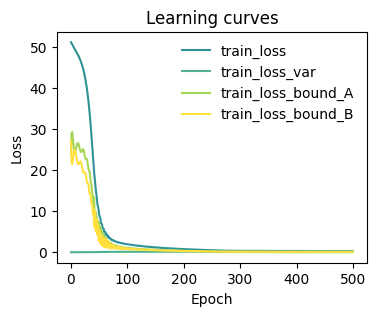

In [24]:
from lightning import Trainer
from mlcolvar.utils.trainer import MetricsCallback
from lightning.pytorch.callbacks import ModelCheckpoint
from mlcolvar.utils.plot import plot_metrics
import matplotlib.pyplot as plt

# define callbacks
metrics = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath="./modelsave/", save_top_k=10, monitor="train_loss_epoch", every_n_epochs=50)

trainer = Trainer(
    callbacks=[metrics, checkpoint_callback],
    logger=False,
    enable_checkpointing=True,
    accelerator='cuda',
    max_epochs=500,
    enable_model_summary=False,
    limit_val_batches=0, 
    num_sanity_val_steps=0
)

trainer.fit(model, datamodule_graph)

fig, ax = plt.subplots(1,1,figsize=(4,3))
plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var', 'train_loss_bound_A', 'train_loss_bound_B'],
                  colors=['fessa1', 'fessa2', 'fessa3', 'fessa4'],
                  yscale='linear',
                  ax = ax)

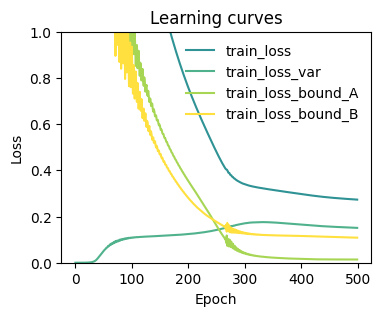

In [26]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.set_ylim(0,1)
plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var', 'train_loss_bound_A', 'train_loss_bound_B'],
                  colors=['fessa1', 'fessa2', 'fessa3', 'fessa4'],
                  yscale='linear',
                  ax = ax)

In [12]:
load_args = [
    #{'start' : 0, 'stop' : 1000, 'stride' : 1},
            #   {'start' : 0, 'stop' : 10000, 'stride' : 10},
               {'start' : 0, 'stop' : 20000, 'stride' : 1}
            ]
dataset_test = create_dataset_from_trajectories(
    trajectories=[
        # "/home/etrizio@iit.local/alad/boundary/A/alad.trr",
        # "/home/etrizio@iit.local/alad/boundary/B/alad.trr",
        "/home/etrizio@iit.local/alad/iteration_1/md/alad.trr"
    ],
    top=[
        # "/home/etrizio@iit.local/alad/boundary/A/alad.gro",
        "/home/etrizio@iit.local/alad/boundary/B/alad.gro",
        # "/home/etrizio@iit.local/alad/boundary/A/alad.gro"
         ],
    cutoff=10.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False,
    load_args=load_args
    )

colvar = load_dataframe("/home/etrizio@iit.local/alad/iteration_1/md/colvar", stop=20000)

datamodule_test = DictModule(dataset_test, lengths=[1], shuffle=False, random_split=False)


[ACE1-CH3, ACE1-C, ACE1-O, ALA2-N, ALA2-CA, ALA2-CB, ALA2-C, ALA2-O, NME3-N, NME3-C]


/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/data/datamodule.py:136: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


In [27]:
import copy
sigmoid = copy.deepcopy(model.sigmoid)

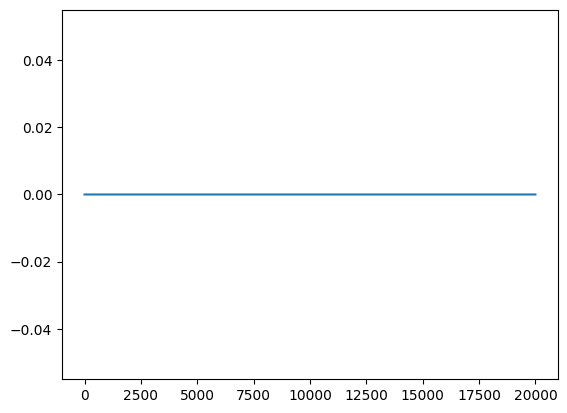

In [31]:
datamodule_test.setup()
loader = datamodule_test
test = next(iter(loader.train_dataloader()))['data_list']

model.sigmoid = None
out_graph = model(test)
plt.plot(test['graph_labels'].numpy())

In [32]:
out_graph

tensor([[-2.1484],
        [-2.6768],
        [-2.7178],
        ...,
        [-0.3951],
        [ 1.9461],
        [-2.2958]], grad_fn=<AddmmBackward0>)

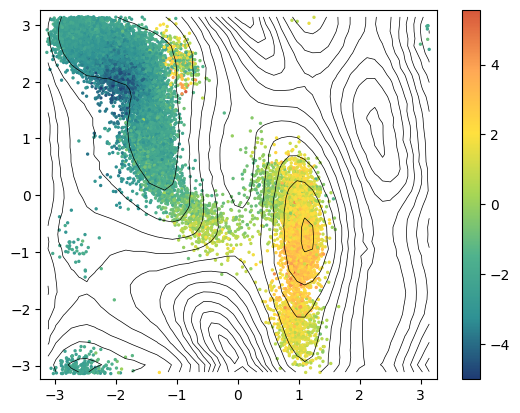

In [33]:
import matplotlib.pyplot as plt
import numpy as np

ref = np.load('/home/etrizio@iit.local/notebooks/projects/kolmogorov_opes/alanine_long_train/refs/alanine_fes.npz')
plt.contour(ref['bins1'], ref['bins2'], ref['fes'], 15, colors='k', linewidths=0.5)
# plt.hist(out_graph.detach().squeeze())
# plt.scatter(torch.arange(len(dataset)).numpy(), out_graph.detach().squeeze(), c=[dataset['data_list'][i]['graph_labels'] for i in range(len(dataset))])
cp = plt.scatter(colvar['phi'], colvar['psi'], c=out_graph[:].detach().squeeze().numpy(), cmap='fessa', s=2)
plt.colorbar(cp)
# plt.ylim(0,1)
plt.show()